# Import & Loading

In [1]:
#basic libaries
import pandas as pd
import numpy as np
import re
import random
import csv

#visualization libaries
import seaborn as sns
import matplotlib. pyplot as plt
%matplotlib inline
import plotly.express as px


#warning libaries
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import chi2,f_classif,SelectKBest
from sklearn.preprocessing import LabelEncoder

In [5]:
data_part_1=pd.read_csv('train.csv')
data_part_2=pd.read_csv('test.csv')
df=pd.concat([data_part_1,data_part_2],axis=0)
df=df.rename(lambda col: col.lower(), axis=1).rename(lambda col: col.strip(), axis=1)
df.rename(columns={'nobeyesdad':'obesity_risk_level'}, inplace=True)
df.tail()

,id,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity_risk_level
13835,34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.00000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation,Normal_Weight
13836,34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.00000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
13837,34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.27374,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation,Normal_Weight
13838,34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.00000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation,Normal_Weight
13839,34597,Male,26.490926,1.812259,120.980508,yes,yes,2.744994,3.00000,Sometimes,no,2.205977,no,1.304291,0.630866,Sometimes,Public_Transportation,Normal_Weight


# Data Cleaning

## Features explanantion

**Gender**: The individual's gender, indicating whether they are male or female.

**Age**: The age of the individual, representing their age in years.

**Height**: The height of the individual, typically measured in meters.

**Weight**: The weight of the individual, typically measured in kilograms.

**family_history_with_overweight**: Indicates whether there is a family history of overweight for the individual (yes/no).

**FAVC**: Stands for "Frequency of consuming high caloric food," representing how often the individual consumes high-calorie foods (yes/no).

**FCVC**: Stands for "Frequency of consuming vegetables," representing how often the individual consumes vegetables.

**NCP**: Stands for "Number of main meals," indicating the number of main meals the individual consumes daily.

**CAEC**: Stands for "Consumption of food between meals," representing the frequency of consuming food between meals.

**SMOKE**: Indicates whether the individual smokes or not (yes/no).

**CH2O**: Represents the amount of water consumption for the individual.

**SCC**: Stands for "Calories consumption monitoring," indicating whether the individual monitors their calorie consumption (yes/no).

**FAF**: Stands for "Physical activity frequency," representing the frequency of the individual's physical activities.

**TUE**: Stands for "Time using technology devices," indicating the amount of time the individual spends using technology devices.

**CALC**: Stands for "Consumption of alcohol," representing the frequency of alcohol consumption.

**MTRANS**: Stands for "Mode of transportation," indicating the mode of transportation the individual uses.

**NObeyesdad**: The target variable, representing the obesity risk category of the individual. It has multiple classes such as 'Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', 'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I', and 'Obesity_Type_I'.

In [6]:
def fix_wrong_obesety_data(bmi,category):
  """fix wrong data tagged as wrong class- I found out some smaples tagged as 'Normal_Weight'
   while they are weight way more then 2 std of the avergae weight of 'Normal_Weight'"""
  if bmi>30 and bmi<35 and category=='Normal_Weight':
    category='Obesity_Type_I'

  if bmi>=35 and bmi<40  and category=='Normal_Weight':
    category='Obesity_Type_II'

  if bmi>=40 and category=='Normal_Weight':
    category='Obesity_Type_III'

  return category

In [7]:
# age is float ->> round it to be int
df['age']=df['age'].apply(lambda x: round(x))
# family_history_with_overweight is object ->> turn it to boolean
df['family_history_with_overweight']=df['family_history_with_overweight'].map({'yes':True,'no':False})
# FAVC: Stands for "Frequency of consuming high caloric food," representing how often the individual consumes high-calorie foods
df['favc']=df['favc'].map({'yes':True,'no':False})
#smoke : object type ->> bool
df['smoke']=df['smoke'].map({'yes':True,'no':False})
#scc : object type ->> bool
df['scc']=df['scc'].map({'yes':True,'no':False})
#using height and weight to create a new feature of bmi
df['bmi']=df.apply(lambda x: (x.weight/np.square(x.height)),axis=1)
#drop columns we won't use with model
df.drop(columns=['id','height','weight'],axis=1, inplace=True)
df['obesity_risk_level']=df.apply(lambda x: fix_wrong_obesety_data(x.bmi,x.obesity_risk_level), axis=1 )

df.head()

,gender,age,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity_risk_level,bmi
0,Male,24,True,True,2.000000,2.983297,Sometimes,False,2.763573,False,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18,True,True,2.000000,3.000000,Frequently,False,2.000000,False,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18,True,True,1.880534,1.411685,Sometimes,False,1.910378,False,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,21,True,True,3.000000,3.000000,Sometimes,False,1.674061,False,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,32,True,True,2.679664,1.971472,Sometimes,False,1.979848,False,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151


In [8]:
def features_data_explantory(df):
  """a methods that try to describe the data and put a first light spot on the data before start to clean it"""
  print(f"dataset shape:\t{df.shape}")
  table=pd.DataFrame(df.dtypes, columns=['type']).reset_index()
  table['features']=table['index']
  table=table[['features','type']]
  table['%nulls']=df.isnull().sum().values/len(df)
  table['#uniques']=df.nunique().values
  table['%uniques']=df.nunique().values/len(df)


  return table


features_data_explantory(df)

dataset shape:	(34598, 16)


,features,type,%nulls,#uniques,%uniques
0,gender,object,0.0,2,0.000058
1,age,int64,0.0,42,0.001214
2,family_history_with_overweight,bool,0.0,2,0.000058
3,favc,bool,0.0,2,0.000058
4,fcvc,float64,0.0,1054,0.030464
5,ncp,float64,0.0,793,0.022920
6,caec,object,0.0,4,0.000116
7,smoke,bool,0.0,2,0.000058
8,ch2o,float64,0.0,1734,0.050119
9,scc,bool,0.0,2,0.000058


# EDA

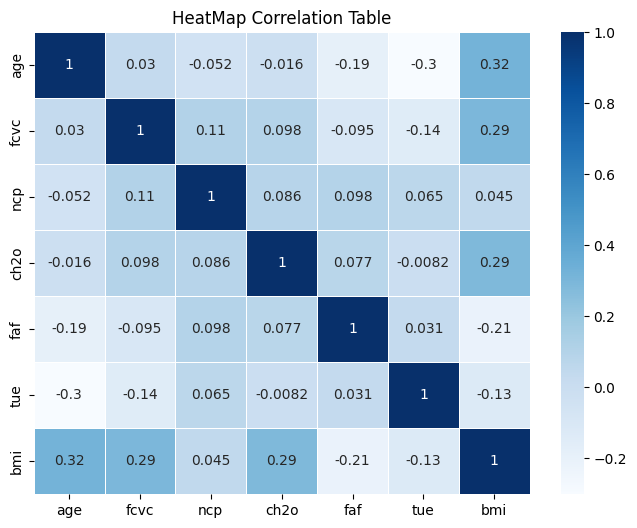

In [9]:
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(data=df.select_dtypes('number').corr(),annot=True,linewidth=0.7,cmap='Blues')
plt.title('HeatMap Correlation Table')
plt.show()

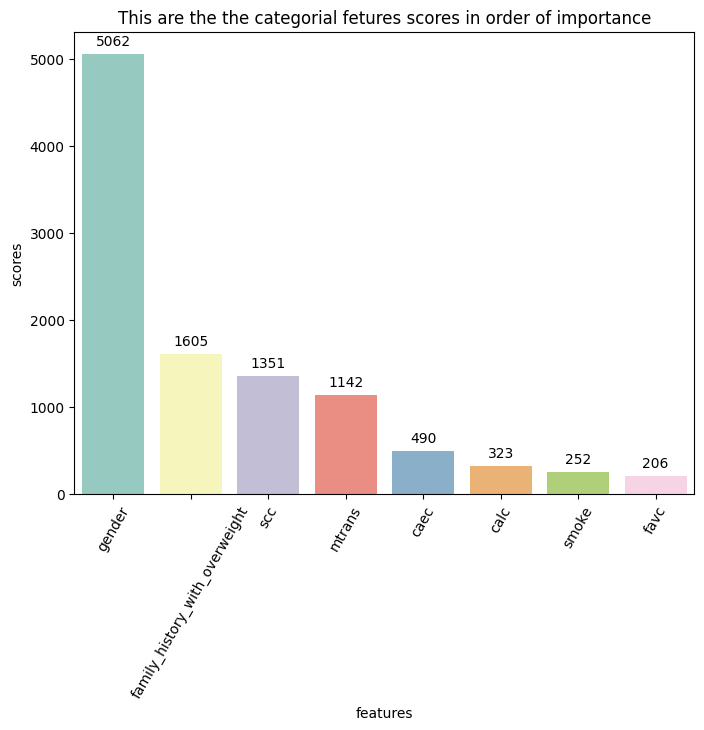

In [10]:
# Encode the categorical features
encoder=LabelEncoder()
X_encoded=df[['gender','caec','calc','smoke','mtrans','scc','family_history_with_overweight','favc']]
for col in X_encoded.columns:
    X_encoded[col] = encoder.fit_transform(X_encoded[col])

# Encode the categorical target variable
encoder_target = LabelEncoder()
y_encoded = encoder_target.fit_transform(df['obesity_risk_level'])

# Create an instance of SelectKBest with the chi2 test
X_data_new=SelectKBest(chi2, k=8).fit(X_encoded, y_encoded)

kbest_dict={}
[feat for feat in X_data_new.get_feature_names_out() ]
[score for score in X_data_new.scores_ ]

for i in range(8):
  kbest_dict[X_data_new.get_feature_names_out()[i]]=X_data_new.scores_[i]


kbest_dict_sorted=sorted(kbest_dict.items(),key=lambda col: col[1],reverse=True)

df_kbest=pd.DataFrame(kbest_dict_sorted,columns=['features','scores'])
#print(f" This are the the fetures scores in order of importance \n{kbest_dict_sorted}")

plt.figure(figsize=(8,6),dpi=100)
ax=sns.barplot(data=df_kbest, x='features',y='scores',palette='Set3')
plt.title('This are the the categorial fetures scores in order of importance')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.xticks(rotation=60)
plt.show()

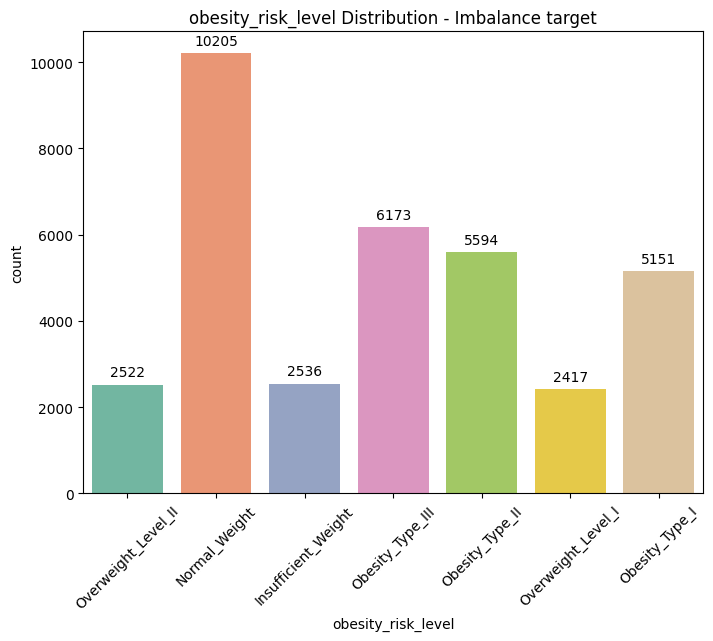

In [11]:
plt.figure(figsize=(8,6),dpi=100)
ax1=sns.countplot(data=df, x='obesity_risk_level', palette='Set2')
plt.title('obesity_risk_level Distribution - Imbalance target')

for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')

plt.xticks(rotation=45)
plt.show()

In [12]:
fig=px.pie(data_frame=df,names='obesity_risk_level', title="Interactive obesity_risk_level Distribution",hole=.3)
fig.show()

In [13]:
fig = px.scatter(df, x="bmi", y="age", color="obesity_risk_level",
                 size='bmi', hover_data=['bmi'])
fig.show()

In [18]:
df['obesity_risk_level'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

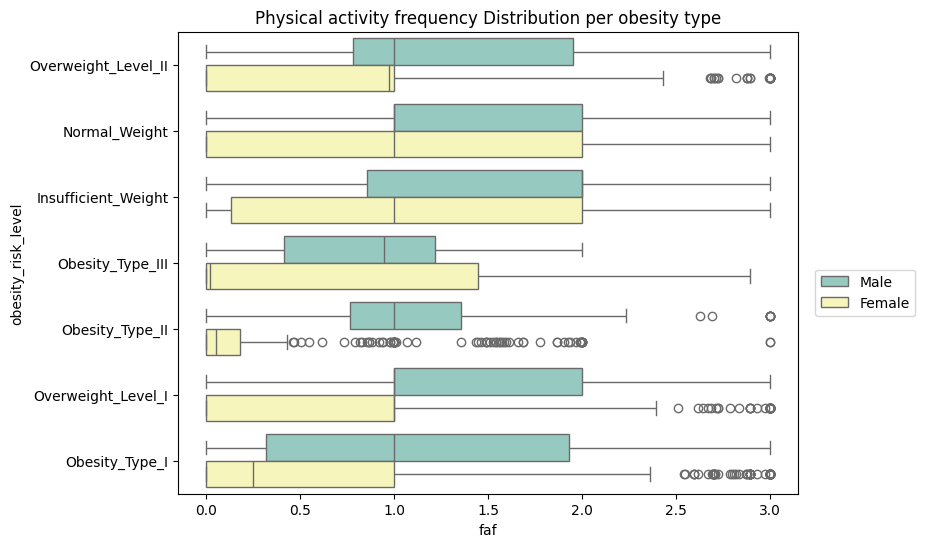

In [14]:
plt.figure(figsize=(8,6),dpi=100)
sns.boxplot(data=df, y='obesity_risk_level',x='faf',hue='gender', palette='Set3')
plt.title('Physical activity frequency Distribution per obesity type')
plt.legend(bbox_to_anchor=(1.2,0.5))
plt.show()

### so we are facing imbalanced data occasion on a multy class target therefore we can resample the other classes or undersample the majority class


# Preproccessing

In [15]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score,fbeta_score,roc_curve,make_scorer,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,roc_auc_score
from sklearn.model_selection import train_test_split as split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours, NearMiss

In [51]:
X=df.drop(columns=['obesity_risk_level'], axis=1)
y=df['obesity_risk_level']

#convert the target to categorial feature
y=y.map({'Insufficient_Weight':0,'Normal_Weight':1,'Overweight_Level_I':2,'Overweight_Level_II':3,'Obesity_Type_I':4,"Obesity_Type_II":5,'Obesity_Type_III':6})


#split the data
X_train,X_test,y_train,y_test=split(X,y,test_size=0.2,shuffle=True,random_state=42)


# rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


In [17]:
class myOneHotEncoder(BaseEstimator,TransformerMixin):
  def __init__(self):
    """constructor"""
    self.ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')

  def fit(self,X,y=None):
    """fit the non numric data on ohe object/bool"""
    self.ohe.fit(X[['gender','caec','calc','smoke','mtrans','scc','family_history_with_overweight','favc']])

    return self


  def transform(self,X):
    """transform the categorical data and mix it with the numeric data"""
    cat_transformed_data=pd.DataFrame(self.ohe.transform(X[['gender','caec','calc','smoke','mtrans','scc','family_history_with_overweight','favc']]))
    numeric_data=X.drop(columns=['gender','caec','calc','smoke','mtrans','scc','family_history_with_overweight','favc'],axis=1)
    transformed_data= np.concatenate([cat_transformed_data,numeric_data],axis=1)

    return transformed_data



In [18]:
# create a pipline
my_pipe=Pipeline(steps=[  ("ohe",myOneHotEncoder()),
                          ("scaler",MinMaxScaler())])

# make the final X matrix to input the model
X_train_model=my_pipe.fit_transform(X_train)
X_test_model=my_pipe.transform(X_test)


# down_sampler=RandomUnderSampler(random_state=42,sampling_strategy={0:1887,1:5000,2:1827,3:1884,4:2180,5:2478,6:3037})
# X_train_model_samp,y_train_samp=down_sampler.fit_resample(X_train_model,y_train)
# near_miss=NearMiss(version=1, n_neighbors=3)
# X_train_model_ds,y_train_ds=near_miss.fit_resample(X_train_model,y_train)

# Model

## XGBoost

In [19]:
#initiate the model
my_xgb=XGBClassifier()

#set the hyperparameters
learning_rate=[0.01,0.05,0.1,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
min_samples_split=[3,5,7,10,20]
subsample=[0.5,0.8,1]

model_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'min_samples_split':min_samples_split,
            'max_features': max_features}


rand_model=RandomizedSearchCV(estimator=my_xgb,param_distributions=model_params,n_iter=5,scoring='f1_macro',random_state=42)

In [20]:
rand_model.fit(X_train_model,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.25],
                                        'max_depth': [2, 3, 5, 7, 10],
                                        'max_features': [0.25, 0.5, 0.75, 1],
                                        'min_samples_split': [3, 5, 7, 10, 20],
                                        'n_estimators': [50, 100],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.8, 1]},
                   random_state=42, scoring='f1_macro')

In [21]:
y_pred=rand_model.predict(X_test_model)
y_proba=rand_model.predict_proba(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.57      0.76      0.65       504
           1       0.70      0.66      0.68      2062
           2       0.49      0.47      0.48       474
           3       0.49      0.51      0.50       530
           4       0.85      0.84      0.85      1043
           5       0.91      0.81      0.85      1091
           6       0.90      0.98      0.94      1216

    accuracy                           0.75      6920
   macro avg       0.70      0.72      0.71      6920
weighted avg       0.75      0.75      0.75      6920



In [40]:
rand_model.predict_proba(X_test_model)

array([[0.0845236 , 0.28545702, 0.10588465, ..., 0.16016908, 0.08491585,
        0.08447313],
       [0.07799092, 0.24625736, 0.07809492, ..., 0.07896791, 0.36273712,
        0.07800841],
       [0.07824866, 0.26045814, 0.078353  , ..., 0.07919186, 0.07804178,
        0.3475057 ],
       ...,
       [0.08295102, 0.28285348, 0.08478278, ..., 0.2666646 , 0.09103671,
        0.08354709],
       [0.08068762, 0.25084293, 0.08079522, ..., 0.0816984 , 0.0804743 ,
        0.34486312],
       [0.0784667 , 0.2589591 , 0.07857133, ..., 0.07941253, 0.07825924,
        0.34791228]], dtype=float32)

In [22]:
rand_model.best_params_

{'subsample': 0.5,
 'scale_pos_weight': 1,
 'n_estimators': 100,
 'min_samples_split': 7,
 'max_features': 1,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0.2}

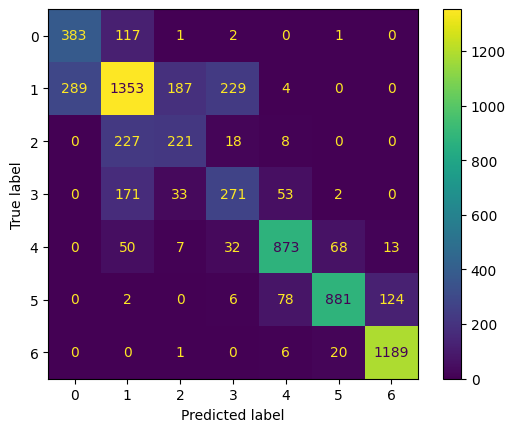

In [23]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=rand_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rand_model.classes_)
disp.plot()
plt.show()

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)

criterion=['gini','entropy']
max_depth=[3,5,7]
max_features=['sqrt','log2']
min_samples_split=[2,3,4]
max_samples=[0.5]

params={'criterion': criterion,'max_depth' : max_depth ,'min_samples_split': min_samples_split, 'max_features':max_features, 'max_samples':max_samples }
grid_model=GridSearchCV(rf,params,cv=4, scoring='f1_macro')

In [25]:
grid_model.fit(X_train_model,y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'], 'max_samples': [0.5],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1_macro')

In [26]:
y_pred=grid_model.predict(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.64      0.19      0.29       504
           1       0.58      0.97      0.73      2062
           2       0.48      0.03      0.05       474
           3       0.75      0.01      0.01       530
           4       0.89      0.81      0.85      1043
           5       0.89      0.84      0.86      1091
           6       0.90      0.99      0.94      1216

    accuracy                           0.73      6920
   macro avg       0.73      0.55      0.53      6920
weighted avg       0.74      0.73      0.67      6920



In [27]:
grid_model.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_split': 4}

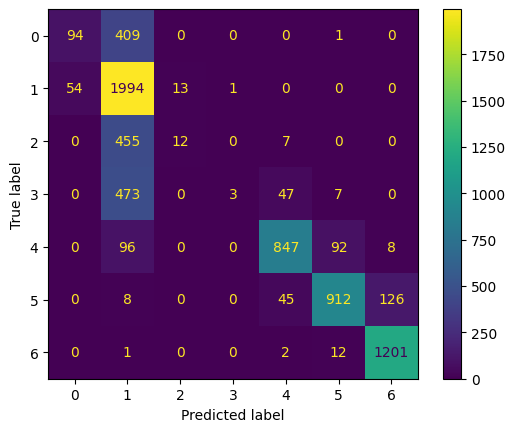

In [28]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=grid_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_model.classes_)
disp.plot()
plt.show()

## Light GBM

In [29]:
!pip install lightgbm
from lightgbm import LGBMClassifier

In [30]:
lgbm=LGBMClassifier()

learning_rate=[0.01,0.05,0.1,0.25]
max_depth=[1,2,3]
n_estimators=[50,100]
num_leaves=[random.randint(6,50)]
max_features=[0.25,0.5,0.75]
subsample=[0.2,0.5,0.8]
objective=['multiclass']
metric = ['multi_logloss']

lgbm_model={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'num_leaves': num_leaves,
            'subsample':subsample,
            'max_features': max_features,
            'objective':objective,
            'metric':metric}


lgbm_model=RandomizedSearchCV(estimator=lgbm,param_distributions=model_params,n_iter=5,scoring='f1_macro',random_state=42)

In [ ]:
lgbm_model.fit(X_train_model,y_train)

In [32]:
y_pred=lgbm_model.predict(X_test_model)
print(classification_report(y_pred=y_pred,y_true=y_test))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_samples_split
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       504
           1       0.68      0.70      0.69      2062
           2       0.52      0.42      0.47       474
           3       0.47      0.46      0.46       530
           4       0.87      0.83      0.85      1043
           5       0.90      0.81      0.86      1091
           6       0.90      0.98      0.94      1216

    accuracy                           0.75      6920
   macro avg       0.70      0.70      0.70      6920
weighted avg       0.75      0.75      0.75      6920



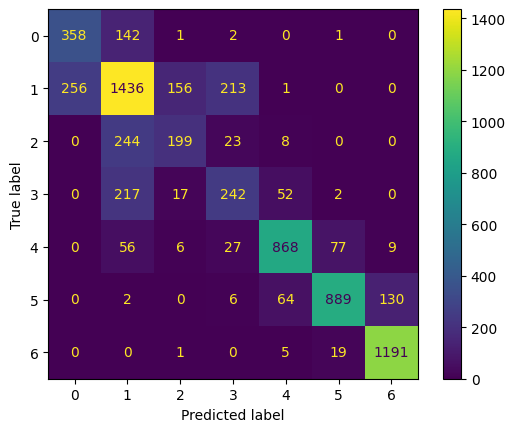

In [33]:
cm = confusion_matrix(y_pred=y_pred,y_true=y_test, labels=grid_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_model.classes_)
disp.plot()
plt.show()

In [34]:
lgbm_model.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 5,
 'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 0.5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.1}

# Conclusion

According to these results choosing XGBoost or Light GBm would work better than Random forest while coosing between them is indifferent

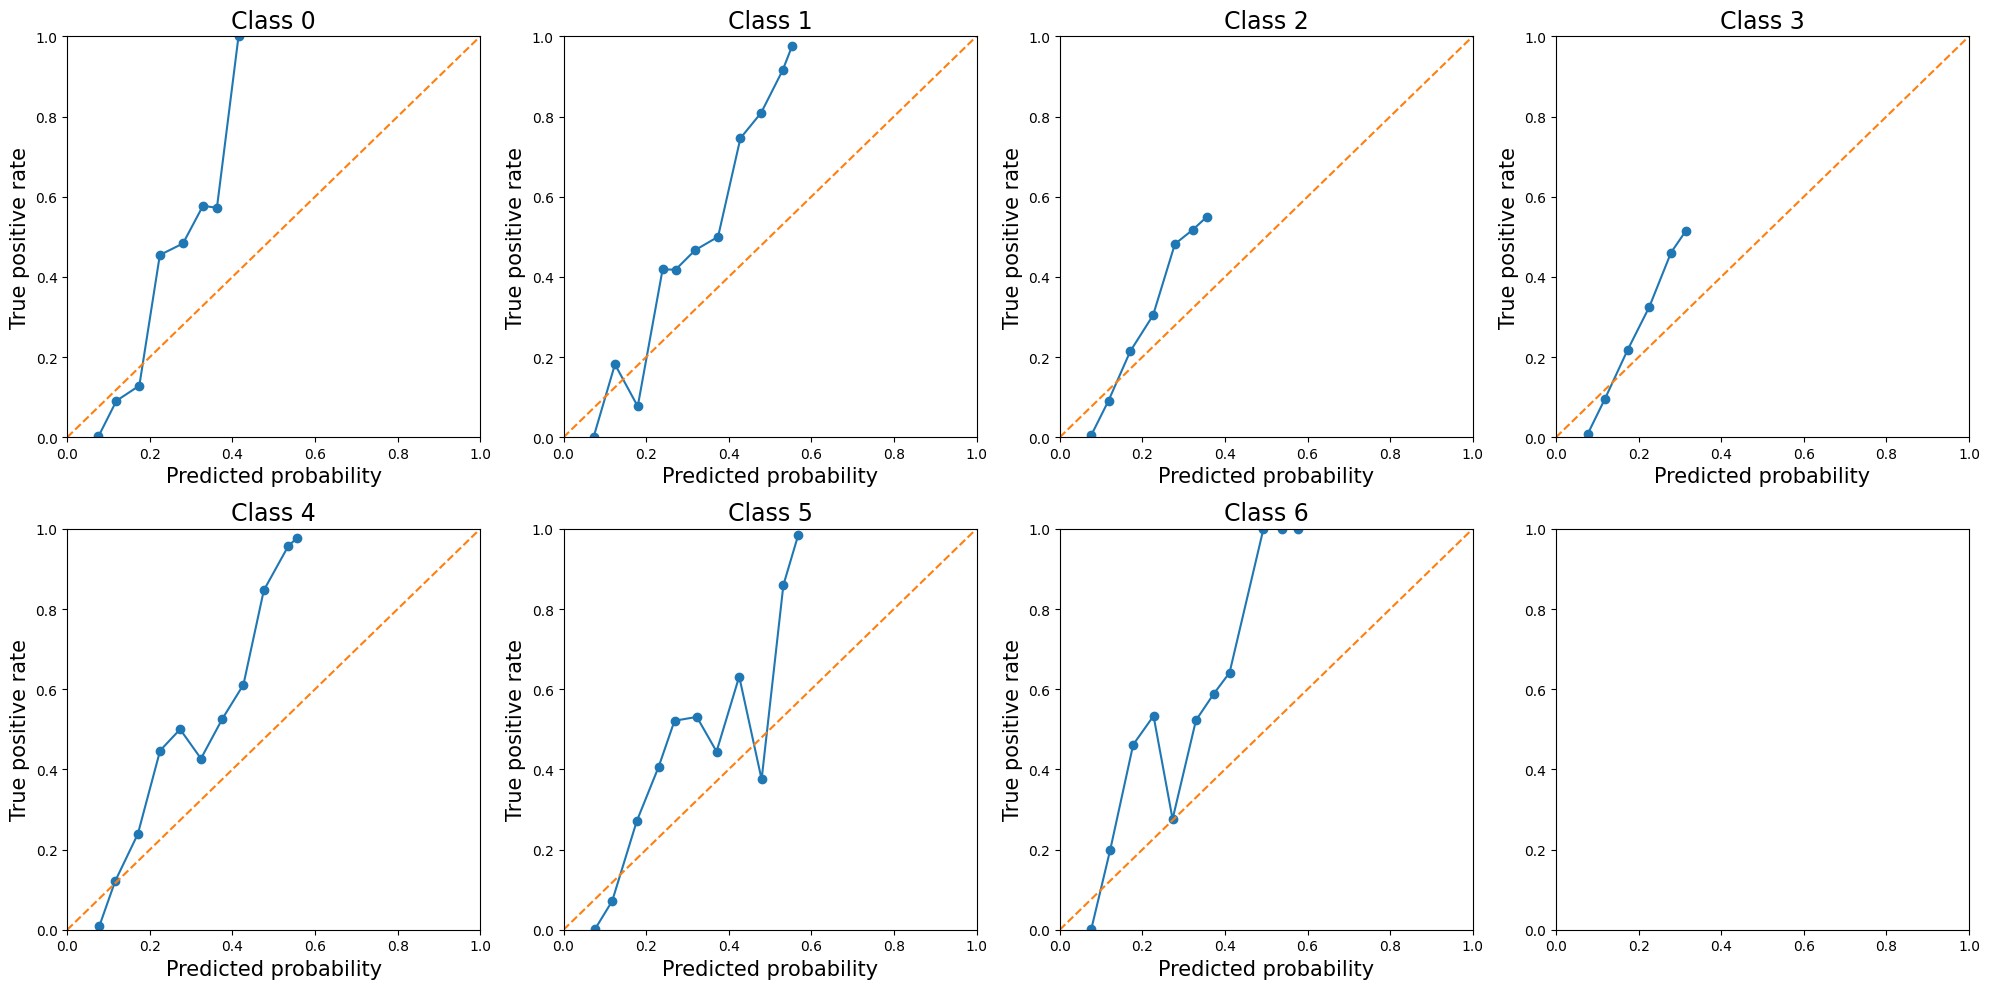

In [58]:
from sklearn.calibration import calibration_curve


num_of_classes=len(rand_model.predict_proba(X_test_model)[0])
probabilities=rand_model.predict_proba(X_test_model)

# Compute the calibration curve for each class
calibration_curve_values = []
for i in range(num_of_classes):
	curve = calibration_curve(y_test == i,
							probabilities[:, i],
							n_bins=20,
							pos_label=True)
	calibration_curve_values.append(curve)

# Plot the calibration curves
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i in range(7):
    axs[i].plot(calibration_curve_values[i][1],
                calibration_curve_values[i][0],
                marker='o')
    axs[i].plot([0, 1], [0, 1], linestyle='--')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_title(f"Class {i}", fontsize=17)
    axs[i].set_xlabel("Predicted probability", fontsize=15)
    axs[i].set_ylabel("True positive rate", fontsize=15)

plt.tight_layout()
plt.show()